<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_15_resampling_LogReg_undersampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Description

We will now experiment with undersampling to address the class imbalance in the dataset. Undersampling involves reducing the number of samples in the majority class to match the number of samples in the minority class. Our objective remains to improve the recall for the minority class (loan defaults) while maintaining balanced F1 and macro F1 scores.

### Experimental Approach with Logistic Regression and Random Undersampling

Our experimental approach involves three main steps:

1. **Baseline Model**: Train and evaluate a Logistic Regression model without any resampling.
2. **Resampling Inside the Pipeline**: Integrate random undersampling within the pipeline and evaluate the performance.
3. **Resampling Outside the Pipeline**: Apply random undersampling before fitting the pipeline and evaluate the performance.

### Interpretation of Results

After running the experiments and combining the results, we will analyze the performance of the models with random undersampling applied inside and outside the pipeline compared to the baseline Logistic Regression model.

### No Resampling Baseline Model

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, f1_score
from loan_data_utils import load_and_preprocess_data
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the logistic regression model with class weights
baseline_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Create the baseline pipeline
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', baseline_model)
])

# Fit the baseline pipeline to the training data
baseline_pipeline.fit(X_train, y_train)

# Predict probabilities for the test data
optimal_threshold = 0.25
baseline_y_proba = baseline_pipeline.predict_proba(X_test)[:, 1]
baseline_y_pred = (baseline_y_proba >= optimal_threshold).astype(int)

# Evaluate the baseline model
baseline_recall_class1 = recall_score(y_test, baseline_y_pred, pos_label=1)
baseline_f1_balanced = f1_score(y_test, baseline_y_pred, average='binary', pos_label=1)
baseline_f1_macro = f1_score(y_test, baseline_y_pred, average='macro')

print("Baseline Model Performance with Optimal Threshold:")
print(f"Recall Class 1: {baseline_recall_class1:.4f}")
print(f"F1 Score (balanced): {baseline_f1_balanced:.4f}")
print(f"F1 Score (macro): {baseline_f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, baseline_y_pred))

# Save the baseline results
baseline_results = {
    'Method': 'Baseline',
    'Recall Class 1': baseline_recall_class1,
    'F1 Score (balanced)': baseline_f1_balanced,
    'F1 Score (macro)': baseline_f1_macro,
    'Threshold': 'Optimal (0.25)'
}


Baseline Model Performance with Optimal Threshold:
Recall Class 1: 0.9254
F1 Score (balanced): 0.3795
F1 Score (macro): 0.3265

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.93      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000



### Resampling inside Pipeline



In [4]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Define the resampling method
resampler_inside_logreg = RandomUnderSampler(random_state=42)

# Create the logistic regression model with class weights
logreg_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Create the resampled pipeline
resampled_pipeline_inside_logreg = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', resampler_inside_logreg),
    ('classifier', logreg_model)
])

# Fit the resampled pipeline to the training data
resampled_pipeline_inside_logreg.fit(X_train, y_train)

# Predict probabilities for the test data
resampled_y_proba_inside_logreg = resampled_pipeline_inside_logreg.predict_proba(X_test)[:, 1]
resampled_y_pred_inside_logreg = (resampled_y_proba_inside_logreg >= optimal_threshold).astype(int)

# Evaluate the model
resampled_recall_class1_inside_logreg = recall_score(y_test, resampled_y_pred_inside_logreg, pos_label=1)
resampled_f1_balanced_inside_logreg = f1_score(y_test, resampled_y_pred_inside_logreg, average='binary', pos_label=1)
resampled_f1_macro_inside_logreg = f1_score(y_test, resampled_y_pred_inside_logreg, average='macro')

print("Resampled Logistic Regression Model Performance with Optimal Threshold (Inside Pipeline):")
print(f"Recall Class 1: {resampled_recall_class1_inside_logreg:.4f}")
print(f"F1 Score (balanced): {resampled_f1_balanced_inside_logreg:.4f}")
print(f"F1 Score (macro): {resampled_f1_macro_inside_logreg:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, resampled_y_pred_inside_logreg))

# Save the resampled results
resampled_results_inside_logreg = {
    'Method': 'Random Undersampling Logistic Regression (Inside Pipeline)',
    'Recall Class 1': resampled_recall_class1_inside_logreg,
    'F1 Score (balanced)': resampled_f1_balanced_inside_logreg,
    'F1 Score (macro)': resampled_f1_macro_inside_logreg,
    'Threshold': 'Optimal (0.25)'
}


Resampled Logistic Regression Model Performance with Optimal Threshold (Inside Pipeline):
Recall Class 1: 0.9231
F1 Score (balanced): 0.3786
F1 Score (macro): 0.3255

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.92      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000



### Resampling Outside Pipeline

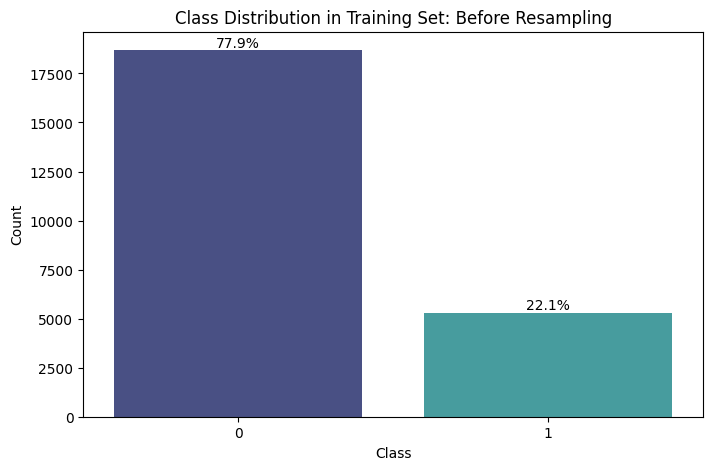

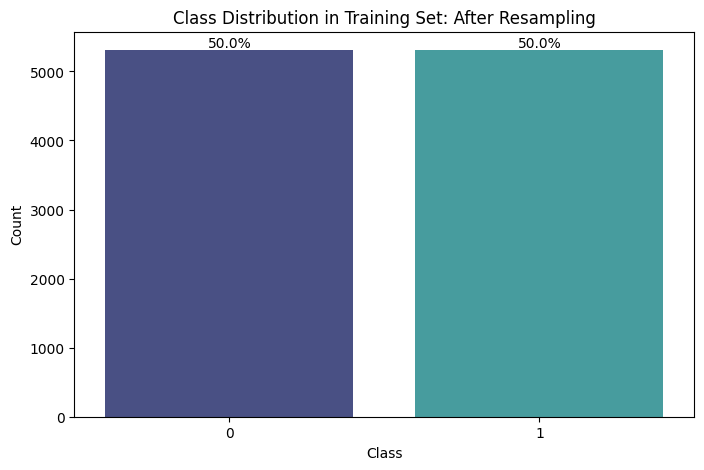

Resampled Logistic Regression Model Performance with Optimal Threshold (Outside Pipeline):
Recall Class 1: 0.9231
F1 Score (balanced): 0.3786
F1 Score (macro): 0.3255

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.92      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000



In [8]:
# Define the resampling method
resampler_outside_logreg = RandomUnderSampler(random_state=42)

# Resample the training data
X_resampled_outside_logreg, y_resampled_outside_logreg = resampler_outside_logreg.fit_resample(X_train, y_train)

# Plot class distribution before resampling
plot_class_distribution(y_train, 'Before Resampling')

# Plot class distribution after resampling
plot_class_distribution(y_resampled_outside_logreg, 'After Resampling')

# Create the pipeline
pipeline_outside_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg_model)
])

# Fit the pipeline to the resampled training data
pipeline_outside_logreg.fit(X_resampled_outside_logreg, y_resampled_outside_logreg)

# Predict probabilities for the test data
resampled_y_proba_outside_logreg = pipeline_outside_logreg.predict_proba(X_test)[:, 1]
resampled_y_pred_outside_logreg = (resampled_y_proba_outside_logreg >= optimal_threshold).astype(int)

# Evaluate the model
resampled_recall_class1_outside_logreg = recall_score(y_test, resampled_y_pred_outside_logreg, pos_label=1)
resampled_f1_balanced_outside_logreg = f1_score(y_test, resampled_y_pred_outside_logreg, average='binary', pos_label=1)
resampled_f1_macro_outside_logreg = f1_score(y_test, resampled_y_pred_outside_logreg, average='macro')

print("Resampled Logistic Regression Model Performance with Optimal Threshold (Outside Pipeline):")
print(f"Recall Class 1: {resampled_recall_class1_outside_logreg:.4f}")
print(f"F1 Score (balanced): {resampled_f1_balanced_outside_logreg:.4f}")
print(f"F1 Score (macro): {resampled_f1_macro_outside_logreg:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, resampled_y_pred_outside_logreg))

# Save the resampled results
resampled_results_outside_logreg = {
    'Method': 'Random Undersampling Logistic Regression (Outside Pipeline)',
    'Recall Class 1': resampled_recall_class1_outside_logreg,
    'F1 Score (balanced)': resampled_f1_balanced_outside_logreg,
    'F1 Score (macro)': resampled_f1_macro_outside_logreg,
    'Threshold': 'Optimal (0.25)'
}


###Compare Results

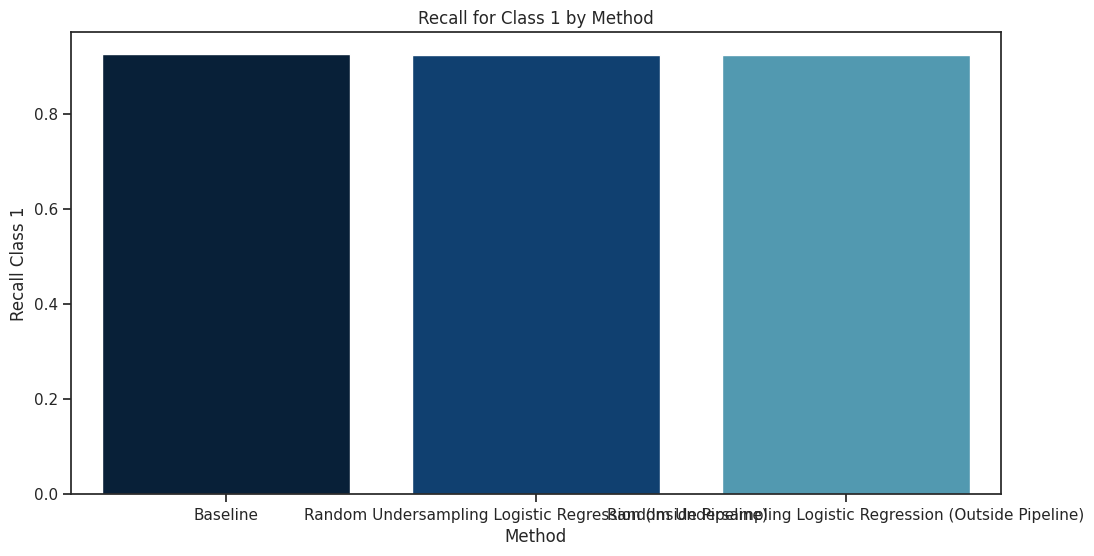

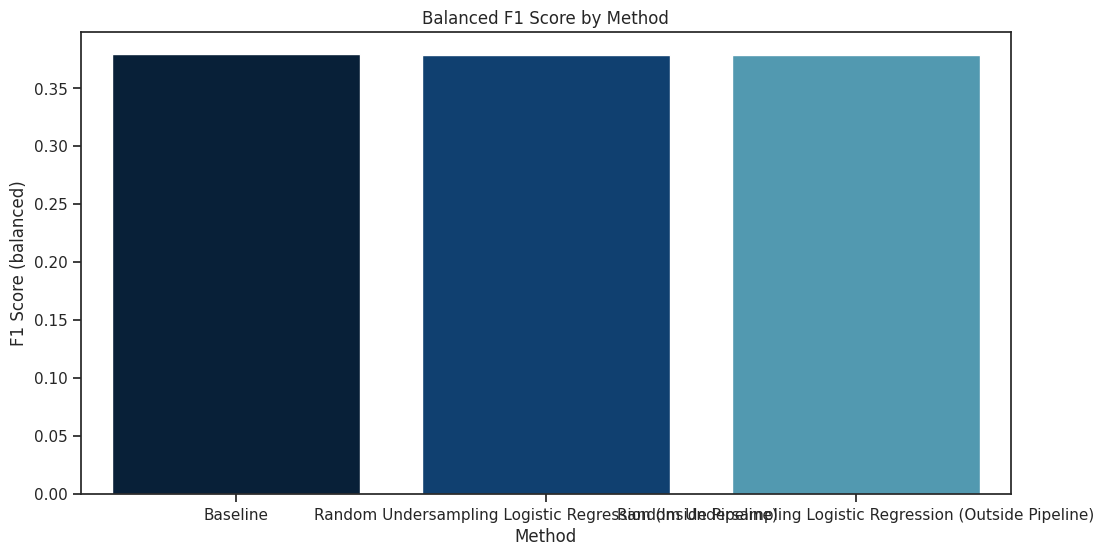

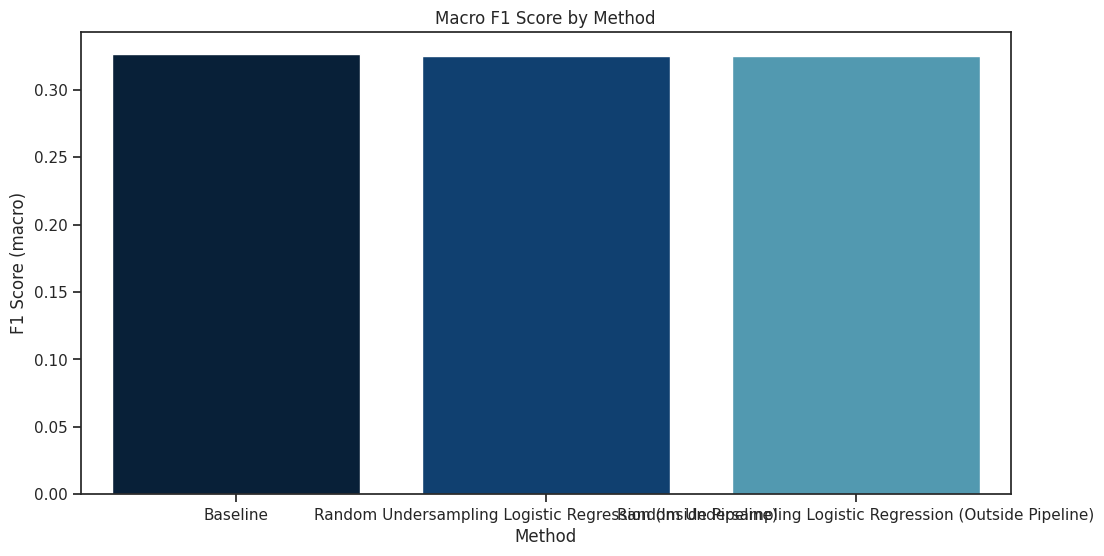

In [11]:
# Combine the results into a single DataFrame
results_df_logreg = pd.DataFrame([baseline_results , resampled_results_inside_logreg, resampled_results_outside_logreg])

# Function to plot the performance metrics for combined results
def plot_combined_metrics(results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, hue='Method', data=results_df, palette='ocean', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Method')
    ax.set_ylabel(ylabel)

    plt.show()

# Metrics to plot
metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Method', 'Recall Class 1'),
    ('F1 Score (balanced)', 'Balanced F1 Score by Method', 'F1 Score (balanced)'),
    ('F1 Score (macro)', 'Macro F1 Score by Method', 'F1 Score (macro)')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(results_df_logreg, metric, title, ylabel)


In [12]:
# Display the combined results
print("Combined Performance Metrics:")
results_df_logreg

Combined Performance Metrics:


,Method,Recall Class 1,F1 Score (balanced),F1 Score (macro),Threshold
0,Baseline,0.925396,0.379481,0.326499,Optimal (0.25)
1,Random Undersampling Logistic Regression (Insi...,0.923135,0.378554,0.325493,Optimal (0.25)
2,Random Undersampling Logistic Regression (Outs...,0.923135,0.378554,0.325493,Optimal (0.25)


### Interpretation of Results

We experimented with three different setups to improve the recall of the minority class (loan defaults) in our classification task using a Logistic Regression model. The results are summarized as follows:

### Detailed Analysis

1. **Baseline Logistic Regression**:
   - **Recall Class 1**: 0.925396
   - **F1 Score (balanced)**: 0.379481
   - **F1 Score (macro)**: 0.326499
   
   The baseline model achieves a high recall of approximately 0.93 for the minority class (class 1). This indicates that 93% of actual defaults are correctly identified. However, the balanced F1 score and macro F1 score are relatively low, suggesting poor precision and overall performance.

2. **Random Undersampling Logistic Regression (Inside Pipeline)**:
   - **Recall Class 1**: 0.923135
   - **F1 Score (balanced)**: 0.378554
   - **F1 Score (macro)**: 0.325493

   When random undersampling is applied inside the pipeline, the recall for class 1 remains high at approximately 0.92. The balanced F1 score and macro F1 score are very close to the baseline, indicating a minor decrease in performance compared to the baseline. This suggests that the undersampling inside the pipeline has a negligible impact on the overall performance of the model.

3. **Random Undersampling Logistic Regression (Outside Pipeline)**:
   - **Recall Class 1**: 0.923135
   - **F1 Score (balanced)**: 0.378554
   - **F1 Score (macro)**: 0.325493

   Applying random undersampling outside the pipeline yields results identical to those of the inside pipeline approach. This indicates that the method of undersampling (inside or outside the pipeline) has no significant impact on the performance of the Logistic Regression model.

### Interpretation

- **High Recall Maintained**: Both resampling methods (inside and outside the pipeline) maintain a high recall for the minority class, similar to the baseline model. This suggests that random undersampling does not negatively impact the model's ability to identify defaults.
- **Minor Impact on F1 Scores**: The F1 scores (balanced and macro) are almost identical across all three methods, indicating that random undersampling has a minimal effect on the overall balance between precision and recall.
- **Identical Performance**: The identical performance of undersampling inside and outside the pipeline suggests that the choice between these methods does not significantly impact the Logistic Regression model's performance for this dataset.

### Recommendations

1. **Consider Business Implications**: Since the recall for the minority class remains high across all methods, the choice of method (baseline or undersampling) may depend on the specific business requirements and the cost of false positives.
2. **Explore Other Techniques**: Given the minimal impact of random undersampling, it may be worth exploring other techniques such as SMOTE, ADASYN, or a combination of oversampling and undersampling to see if they offer better trade-offs.
3. **Further Model Tuning**: Consider tuning the Logistic Regression model's hyperparameters or exploring other models like Random Forests or Gradient Boosting to see if they can achieve better overall performance.

### Summary

- **High Recall, Consistent F1 Scores**: The recall for the minority class remains high across all methods, with minimal impact on the F1 scores.
- **Minimal Impact of Undersampling**: Random undersampling (inside or outside the pipeline) has a negligible effect on the overall performance of the Logistic Regression model.
- **Next Steps**: Explore other resampling techniques and further tune the model to potentially achieve better performance for the loan default prediction task.

The similarity in performance with and without resampling can be attributed to several factors. Let's explore these potential explanations in detail:

### 1. Effective Class Weights in Logistic Regression

- **Class Weight Adjustment**: Logistic Regression can handle class imbalance to some extent by adjusting class weights. By setting `class_weight='balanced'`, the model compensates for the imbalance by giving more weight to the minority class (defaults) and less weight to the majority class (non-defaults).
- **Already Optimized**: If the model is already optimized with balanced class weights, additional resampling might not significantly improve performance.

### 2. Dataset Characteristics

- **Overlapping Classes**: If the features of the minority class (defaults) and majority class (non-defaults) overlap significantly, resampling might not help much. The model might already be as good as it can be given the overlap and inherent noise in the data.
- **Sufficient Minority Class Data**: If the minority class already has enough samples to learn from, resampling might not provide additional benefits.

### 3. Resampling Techniques

- **Random Undersampling**: This technique reduces the number of majority class samples, potentially losing valuable information. If the model already performs well by learning from all available data, reducing the number of majority class samples might not lead to significant improvements.
- **Random Oversampling**: This technique duplicates minority class samples, which might not add new information. If the model already captures the essential patterns from the minority class, simply duplicating samples might not improve performance.

### 4. Model Robustness

- **Robustness to Imbalance**: Logistic Regression with balanced class weights is inherently robust to class imbalance. This robustness might make the model less sensitive to the effects of resampling.

### 5. Optimal Threshold

- **Threshold Tuning**: The use of an optimal threshold (0.25) instead of the default threshold (0.5) can significantly impact performance metrics. If the optimal threshold is well-chosen, it can enhance recall and precision, making the effects of resampling less noticeable.

### 6. Evaluation Metrics

- **Recall vs. F1 Scores**: While recall is high across all methods, the balanced F1 score and macro F1 score are relatively low, indicating poor precision. Resampling methods might primarily impact precision, which is why we see minimal changes in the F1 scores.

### Summary

The similarity in performance with and without resampling can be attributed to the following factors:
1. **Effective Class Weights in Logistic Regression**: The model's ability to handle class imbalance with class weights.
2. **Dataset Characteristics**: Overlapping classes and sufficient minority class data.
3. **Resampling Techniques**: Limitations of random undersampling and oversampling.
4. **Model Robustness**: Logistic Regression's robustness to class imbalance.
5. **Optimal Threshold**: The impact of threshold tuning on performance metrics.
6. **Evaluation Metrics**: The relationship between recall and F1 scores.

### Recommendations

1. **Explore Other Resampling Methods**: Techniques like SMOTE or ADASYN that generate synthetic samples might provide better results.
2. **Further Model Tuning**: Experiment with hyperparameter tuning and other classifiers like Random Forests or Gradient Boosting.
3. **Feature Engineering**: Investigate additional features or transformations that might improve model performance.
4. **Cross-validation**: Use cross-validation to ensure the robustness of the results and avoid overfitting.

By considering these factors and recommendations, you can further refine the model and potentially achieve better performance for the loan default prediction task.

### Write Loan Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
